In [1]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [2]:
arr1 = [pyemma.coordinates.load(f'../sampling_features/feats_prod/ca_ca_{i:03d}.npy') for i in range(11)]

In [3]:
arr2 = [pyemma.coordinates.load(f'../sampling_features/feats_prod/tor_{i:03d}.npy') for i in range(11)]

In [ ]:
np.shape(arr1)

In [11]:
arr3 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_prod/sidechain_dists_{i:03d}.npy') for i in range(11)]

In [59]:
arr3 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_10.3/sidechain_dists_{i:03d}.npy') for i in range(3)]

In [60]:
arr4 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_10.3/coord_{i:03d}.npy') for i in range(3)]

In [61]:
arr5 = [pyemma.coordinates.load(f'../adaptive_sampling_features/feats_10.3/ca_com_{i:03d}.npy') for i in range(3)]

In [6]:
arr4 = [pyemma.coordinates.load(f'../features_v1/ca_com_v1_{i:03d}.npy') for i in range(9)]

In [7]:
arr5 = [pyemma.coordinates.load(f'../features_v1/torsions_v1_{i:03d}.npy') for i in range(9)]

In [8]:
arr6 = [pyemma.coordinates.load(f'../features_v1/ca_v1_{i:03d}.npy') for i in range(9)]

In [9]:
combo_all = [np.concatenate([a1, a2, a3, a4, a5, a6], axis=1) for a1, a2, a3, a4, a5, a6 in zip(arr3, arr4, arr2, arr1, arr5, arr6)]


In [10]:
combo_ext = [np.concatenate([a1, a2, a3, a4], axis=1) for a1, a2, a3, a4 in zip(arr3, arr4, arr2, arr1)]


In [10]:
combo_all = [np.concatenate([a1, a2, a3], axis=1) for a1, a2, a3 in zip(arr1, arr2, arr3)]


In [4]:
combo_all = [np.concatenate([a1, a2], axis=1) for a1, a2 in zip(arr1, arr2)]


In [209]:
np.shape(combo_all[1])

(10001, 74)

Now we have to start loading these into tICA


In [13]:
labels = ['contacts','min_dist','sidechain']

In [14]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


[5.525439754556248]
[4.812801943923747]
[4.244289832918599]


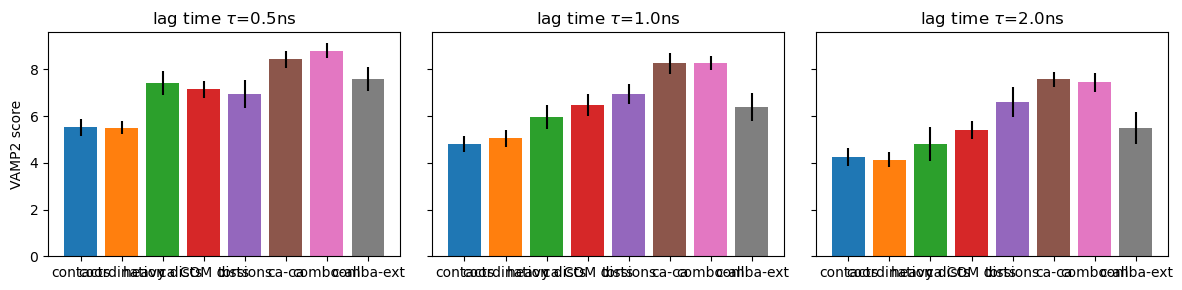

In [33]:


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(arr1, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    print(scores)
    positions_scores = score_cv(arr2, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(arr3, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ca_com_scores = score_cv(arr4, lag=lag, dim=dim)
    scores += [ca_com_scores.mean()]
    errors += [ca_com_scores.std()]
    torsion_scores = score_cv(arr5, lag=lag, dim=dim)
    scores += [torsion_scores.mean()]
    errors += [torsion_scores.std()]
    ca_dist_scores = score_cv(arr6, lag=lag, dim=dim)
    scores += [ca_dist_scores.mean()]
    errors += [ca_dist_scores.std()]
    combo_all_scores = score_cv(combo_all, lag=lag, dim=dim)
    scores += [combo_all_scores.mean()]
    errors += [combo_all_scores.std()]
    combo_ext_scores = score_cv(combo_ext, lag=lag, dim=dim)
    scores += [combo_ext_scores.mean()]
    errors += [combo_ext_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2','C3','C4','C5','C6','C7'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

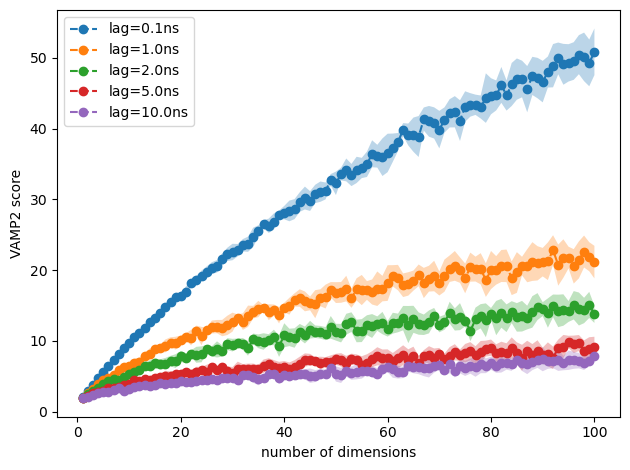

In [13]:
lags = [1, 10, 20, 50, 100]
dims = [i + 1 for i in range(100)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(combo_ext, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [99]:
np.shape(arr1[0])

(17501, 37)

In [5]:
tica_dev = pyemma.coordinates.tica(combo_all, lag=20)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                               | 0…

getting output of TICA:   0%|                                                                              | 0…

In [9]:
np.shape(combo_all[0])

(17501, 74)

In [6]:
np.shape(tica_concatenated)

(130963, 43)

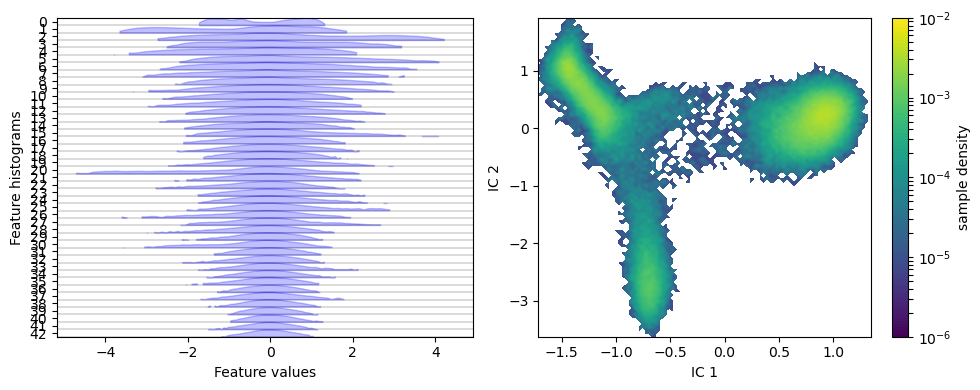

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/plots/plots2d.py:251: UserWarning: bins=2000 is not an allowed optional parameter and will be ignored
  _warn(


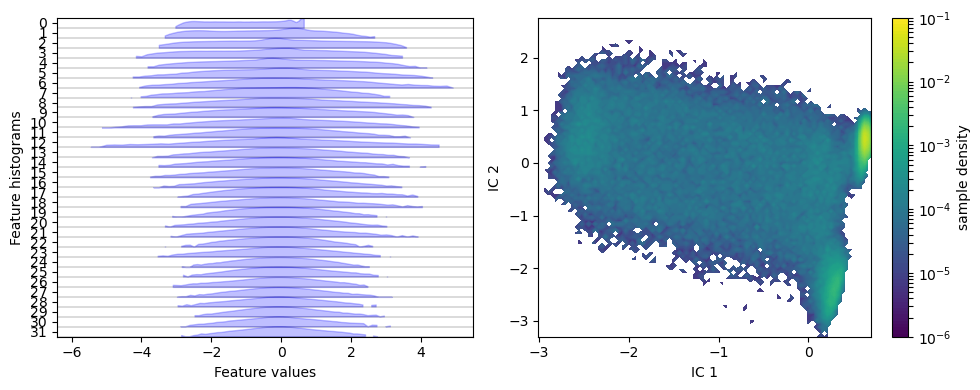

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)

# Increase the number of bins for more granularity
n_bins = 2000
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True, bins=n_bins)

axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)


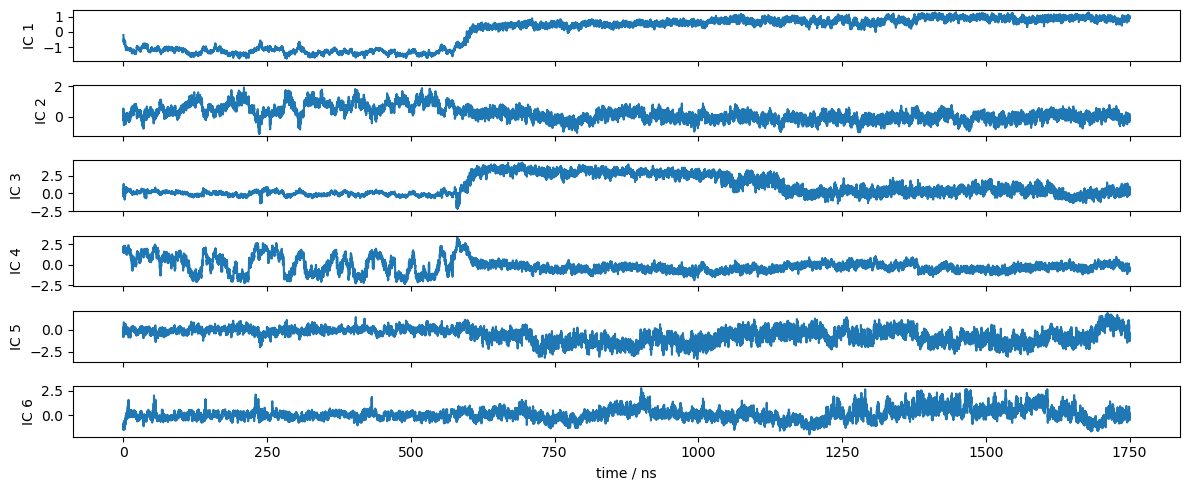

In [213]:
fig, axes = plt.subplots(6, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_out[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_out[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
# plt.savefig('ics_update.png')

In [10]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_out, k=350, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                                                                        | 0/…

kmeans iterations:   0%|                                                                                  | 0/…

getting output of KmeansClustering:   0%|                                                                  | 0…

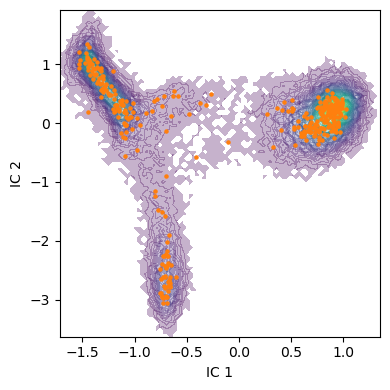

In [227]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                      | 0/17 [00:…

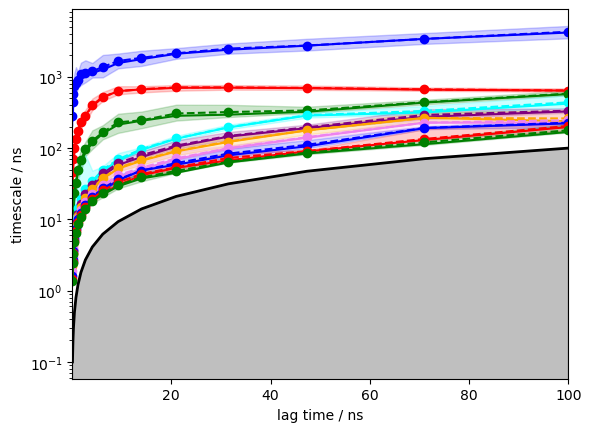

In [228]:
its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

In [229]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=300, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[227]: compute stat. inefficiencies:   0%|        | 0/19376 [00:…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[227]: Sampling MSMs:   0%|                         | 0/100 [00:…

fraction of states used = 1.00
fraction of counts used = 1.00


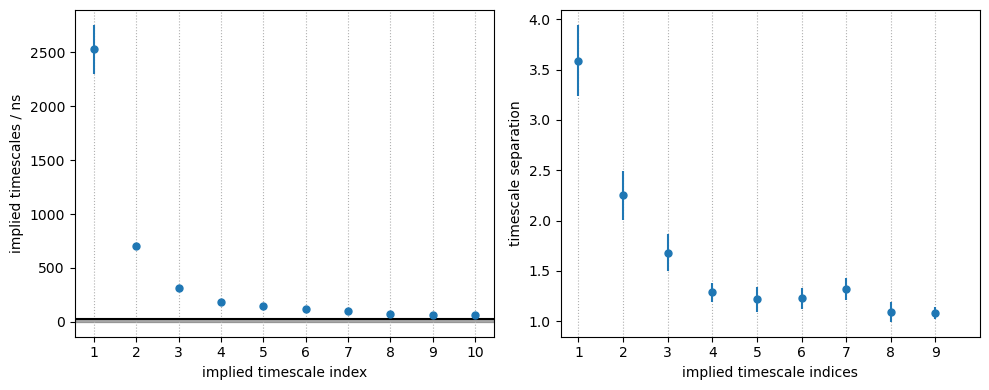

In [230]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('4state_spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                                                                       | 0/9 [00:…

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 348 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 346 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


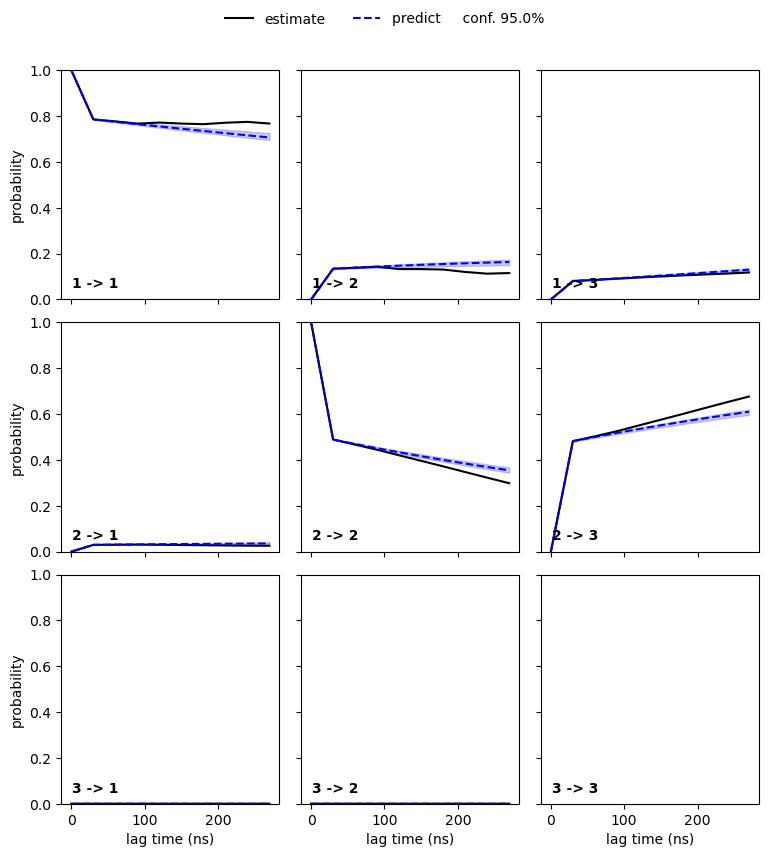

In [231]:
nstates = 3
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

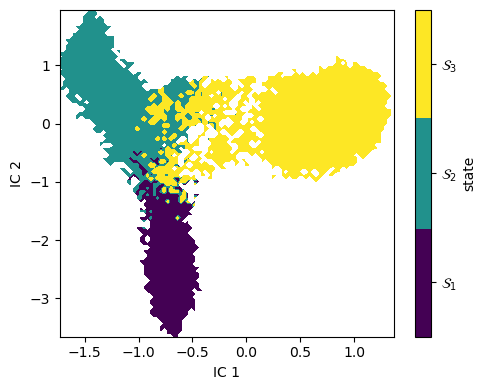

In [232]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

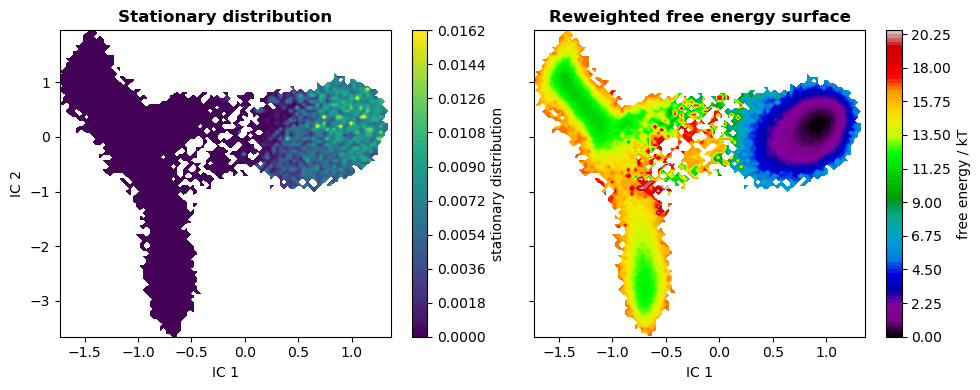

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)

/tmp/ipykernel_2914810/3306271696.py:13: RuntimeWarning: divide by zero encountered in log
  fes_kBT = -np.log(hist)


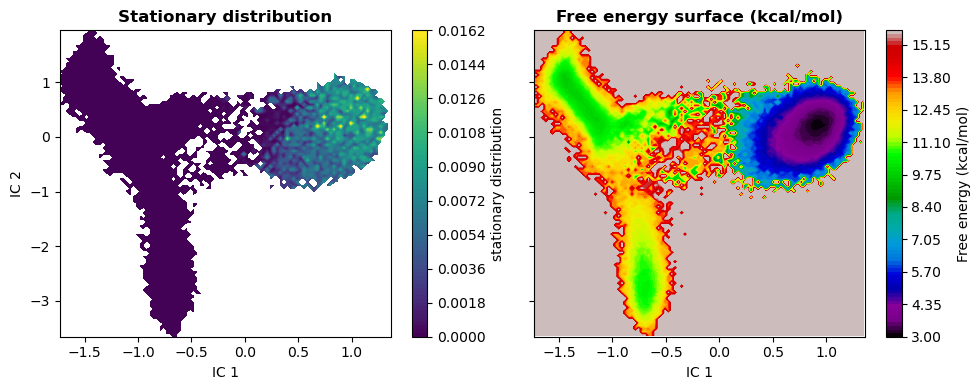

In [234]:
kB = 1.9872036e-3  # kcal/mol·K
T = 310  # You need to provide the temperature in Kelvin

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(
    tica_concatenated[:, 0], tica_concatenated[:, 1], 
    bins=100, weights=np.concatenate(msm.trajectory_weights()))

# Convert histogram to probability
hist /= hist.sum()

# Convert probabilities to free energy in units of kBT
fes_kBT = -np.log(hist)

# Handle infinities
fes_kBT[np.isinf(fes_kBT)] = fes_kBT[~np.isinf(fes_kBT)].max()

# Convert the free energy to kcal/mol
fes_kcal_per_mol = fes_kBT * kB * T

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot stationary distribution
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')

# Plot free energy in kcal/mol
contourf = axes[1].contourf(
    (xedges[:-1] + xedges[1:]) / 2,
    (yedges[:-1] + yedges[1:]) / 2,
    fes_kcal_per_mol.T,  # transpose due to how meshgrid works
    levels=100,  # you can adjust the number of levels or provide explicit levels
    cmap='nipy_spectral'
)
cbar = fig.colorbar(contourf, ax=axes[1])
cbar.set_label('Free energy (kcal/mol)')

for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Free energy surface (kcal/mol)', fontweight='bold')
fig.tight_layout()
# plt.savefig('2state_pmf.png',dpi=400)


In [235]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3
1,0.000000e+00,1197785.92,3031.96
2,2.908491e+08,0.00,999.52
3,3.298934e+08,36819390.83,0.00


In [224]:
# Given your code:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[2:])

mfpt_A_to_B_mean = msm.sample_mean('mfpt', B, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', B, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


8.498310557934319e-07
Off-rate (from A to B): 8.50e-07 ± 1.53e-07 1/ns


In [171]:
# Given your code:
A = msm.metastable_sets[2]
B = np.concatenate(msm.metastable_sets[1:])

mfpt_A_to_B_mean = msm.sample_mean('mfpt', B, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', B, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


IndexError: list index out of range

In [188]:
# Given your code:
C = msm.metastable_sets[1]
A = msm.metastable_sets[0]

mfpt_A_to_B_mean = msm.sample_mean('mfpt', C, A)
mfpt_A_to_B_std = msm.sample_std('mfpt', C, A)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


8.549748188906227e-06
Off-rate (from A to B): 8.55e-06 ± 9.69e-07 1/ns


In [189]:
# Given your code:
C = msm.metastable_sets[1]
A = msm.metastable_sets[0]

mfpt_A_to_B_mean = msm.sample_mean('mfpt', A, C)
mfpt_A_to_B_std = msm.sample_std('mfpt', A, C)

# Calculate the off-rate from the MFPT
k_off_mean = 1 / mfpt_A_to_B_mean
print(k_off_mean)
k_off_std = k_off_mean * (mfpt_A_to_B_std / mfpt_A_to_B_mean)  # Error propagation for the inverse

print(f"Off-rate (from A to B): {k_off_mean:.2e} ± {k_off_std:.2e} 1/ns")


0.0011758965348062343
Off-rate (from A to B): 1.18e-03 ± 5.10e-05 1/ns


In [225]:
import math

def calculate_deltaG(k_on, k_off, temperature):
    R = 8.314  # J/mol·K
    K = k_on / k_off
    deltaG_joule = -R * temperature * math.log(K)
    
    # Convert from J/mol to kcal/mol
    conversion_factor = 0.000239006
    deltaG_kcal = deltaG_joule * conversion_factor

    print(f"k_on = {k_on:.8f} ns^-1")
    print(f"k_off = {k_off:.8f} ns^-1")
    print(f"Equilibrium constant, K = {K:.2f}")
    print(f"Delta G (J/mol) = {deltaG_joule:.2f} J/mol")
    print(f"Delta G (kcal/mol) = {deltaG_kcal:.2f} kcal/mol")

    return deltaG_kcal

mfpt_bound_to_unbound = 1700  # ns
mfpt_unbound_to_bound = 5.0e7   # ns
temperature = 310               # K

k_on = 1.0 / mfpt_unbound_to_bound
k_off = 1.0 / mfpt_bound_to_unbound
deltaG = calculate_deltaG(k_on, k_off, temperature)


k_on = 0.00000002 ns^-1
k_off = 0.00058824 ns^-1
Equilibrium constant, K = 0.00
Delta G (J/mol) = 26518.64 J/mol
Delta G (kcal/mol) = 6.34 kcal/mol
